In [2]:
import torch
import pandas
import matplotlib.pyplot as plt
import torch.nn.functional as F


In [3]:
file=open('/content/drive/MyDrive/building_makemore/names.txt')
words=file.read().split('\n')

In [4]:
len(words)

32033

In [5]:
# making a dictionary
stoi={c:i+1 for i,c in enumerate(sorted(list(set(''.join(words)))))}
stoi['.']=0
itos={i:c for c,i in stoi.items()}

In [6]:
stoi['a']

1

We are building a character level language model

***

### Building a dataset for 5 words

In [7]:
X=[]
Y=[]



for w in words[:5]:

  context=[0]*3
  for ch in w+'.':
    ix=stoi[ch]
    X.append(context[:])
    Y.append(ix)

    #print(''.join(itos[i] for i in context),'gives ',itos[ix])
    context.append(ix)
    context=context[1:]

  


In [8]:
# Converting into a tensor
X=torch.tensor(X)
Y=torch.tensor(Y)

In [9]:
X.shape

torch.Size([32, 3])

In [10]:
# Embedding matrix where each character is represented using 2 cells
C=torch.randn(27,2)

In [11]:
# This is the embedding of char at index 0 which in our case of '.'
C[0]

tensor([-2.5272,  0.8312])

In [12]:
# Confirming our indexing works in pytorch
C[torch.tensor([0,1])]

tensor([[-2.5272,  0.8312],
        [ 0.3193, -1.4087]])

In [13]:
# We have a matrix consisting of concatenated embeddings for the first five samples from words
C[X].reshape(32,-1).shape

torch.Size([32, 6])

### Now we want the hidden layer and weight matrix for it

In [14]:
# our hidden state has 10 neurons
W1=torch.randn(6,100)
b1=torch.randn(100)

In [15]:
b1.shape

torch.Size([100])

In [16]:
C[X][1]

tensor([[-2.5272,  0.8312],
        [-2.5272,  0.8312],
        [-1.5338,  0.6881]])

In [17]:
embedding=C[X].reshape(X.shape[0],-1)

In [18]:
embedding.shape

torch.Size([32, 6])

In [19]:
(embedding@W1).shape

torch.Size([32, 100])

In [20]:
(embedding@W1+b1).shape

torch.Size([32, 100])

In [21]:
h=torch.tanh(embedding@W1+b1)

In [22]:
h.shape

torch.Size([32, 100])

In [23]:
W2=torch.randn(100,27)
b2=torch.randn(27)

W3=torch.randn(6,27)

# implementing skip connection 
logits=h@W2+b2+embedding@W3

In [24]:
loss=F.cross_entropy(logits,Y)

In [25]:
# This is the loss which we want to minimize
loss

tensor(18.3622)

### Making functions and cleaning it more

In [26]:

predictors=[]
target=[]

for w in words:

  context=[0]*3
  for ch in w+'.':
    ix=stoi[ch]
    predictors.append(context[:])
    target.append(ix)

    #print(''.join(itos[i] for i in context),'gives ',itos[ix])
    context.append(ix)
    context=context[1:]

predictors=torch.tensor(predictors)
target=torch.tensor(target)
  




In [79]:
# Initialising an embedding matrix
g = torch.Generator().manual_seed(2147483647)
C=torch.randn((27,2),generator=g)
W1=torch.randn((6,100),generator=g)
b1=torch.randn(100,generator=g)
W2=torch.randn((100,27),generator=g)
b2=torch.randn((27),generator=g)
W3=torch.randn((6,27),generator=g)

parameters = [C, W1, b1, W2, b2,W3]

for p in parameters:
  p.requires_grad=True

In [71]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [80]:


lossi=[]
itr=[]
lr=[]

for i in range(200000):

  ix=torch.randint(0,predictors.shape[0],(32,))

  embedding=C[predictors[ix]].reshape(-1,6)

  # hidden state 1
  h=torch.tanh(embedding@W1+b1)

  # output logits 
  # making use of skip connection as well
  logits=h@W2+b2+embedding@W3

  


  #loss function

  loss=F.cross_entropy(logits,target[ix])

  for p in parameters:
    p.grad=None

  loss.backward()

  lr=0.1 if i <100000 else 0.01
  for p in parameters:
    p.data+=-lr*(p.grad)
  

  lossi.append(loss.log().item())
  itr.append(i)
  #lr.append(lrs[i])




  
  


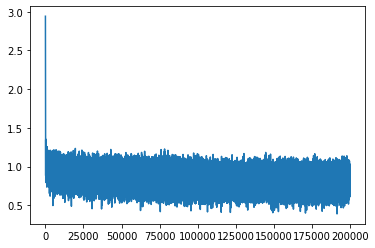

In [81]:
# From this plot, we can say that lr of about 0.1 seems to be optimal
plt.plot(itr,lossi)

In [82]:
emb =C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2+emb.view(-1,6)@W3 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss¢

tensor(2.1934, grad_fn=<NllLossBackward0>)

### To complete with train/dev/test split, sampling and generating words out of it.